## 80

In [1]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-07-09 09:17:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [         <=>        ]  27.87M  11.6MB/s    in 2.4s    

2023-07-09 09:17:10 (11.6 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録、ここで多分、0から始めた方がいいでしょ。だってpadding_idxのことかんがえたら

print(f'ID数: {len(set(word2id.values()))}\n')
print('頻度上位20語')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 9405

頻度上位20語
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


In [5]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]#word2id辞書から単語を検索し、単語が見つかった場合は対応する単語IDを返し、見つからない場合はunkで指定された値を返します。

In [6]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


## 81


パッディングとは


In [7]:
import torch
from torch import nn
#vocab_size->(enb_size->hidden_size)()->out_put_size
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)#padding_idxの値の時の入力データは全て0となり学習が進まなくなる。バッチサイズでは入力単語長が一定でなきゃエラーだからこれで単語長揃える
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0] # ここのためにX.unsqueeze(0)している（モデルに渡した分だけバッチサイズとなる）
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])#最後の時刻の出力
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)#すべて１
    return hidden

In [8]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [9]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


In [10]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID(パディングidはword2idに入っていない単語の時に使う。)
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))  #9405はmicrobesに対応しているけどこれに関しては学習しないってこと、それとも内部でid1がインデックス0に対応的な感じで1ずつずれてて、0がlen(set(word2id.values())) になるってこと？？
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  #print(X.device)
  #print(X)
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.1249, 0.1472, 0.2212, 0.5067]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2379, 0.3379, 0.2882, 0.1360]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4010, 0.2286, 0.1967, 0.1736]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1761, 0.3318, 0.2441, 0.2479]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1556, 0.3601, 0.1741, 0.3102]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3471, 0.2908, 0.2104, 0.1517]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2211, 0.3181, 0.2174, 0.2434]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3081, 0.1166, 0.1122, 0.4630]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2667, 0.3929, 0.1333, 0.2070]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3459, 0.3371, 0.2108, 0.1063]], grad_fn=<SoftmaxBackward0>)


## 82

In [11]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [12]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1038, accuracy_train: 0.5169, loss_valid: 1.1264, accuracy_valid: 0.5052, 59.5267sec
epoch: 2, loss_train: 1.0159, accuracy_train: 0.5871, loss_valid: 1.0705, accuracy_valid: 0.5659, 61.7851sec
epoch: 3, loss_train: 0.8582, accuracy_train: 0.6804, loss_valid: 0.9577, accuracy_valid: 0.6385, 58.7843sec
epoch: 4, loss_train: 0.7156, accuracy_train: 0.7402, loss_valid: 0.8607, accuracy_valid: 0.6909, 51.7620sec
epoch: 5, loss_train: 0.6036, accuracy_train: 0.7812, loss_valid: 0.7675, accuracy_valid: 0.7328, 51.9004sec
epoch: 6, loss_train: 0.5336, accuracy_train: 0.8088, loss_valid: 0.7282, accuracy_valid: 0.7403, 55.6860sec
epoch: 7, loss_train: 0.4854, accuracy_train: 0.8202, loss_valid: 0.6974, accuracy_valid: 0.7433, 53.2524sec
epoch: 8, loss_train: 0.4450, accuracy_train: 0.8338, loss_valid: 0.6714, accuracy_valid: 0.7650, 52.5174sec
epoch: 9, loss_train: 0.4290, accuracy_train: 0.8396, loss_valid: 0.6613, accuracy_valid: 0.7582, 52.3851sec
epoch: 10, loss_tra

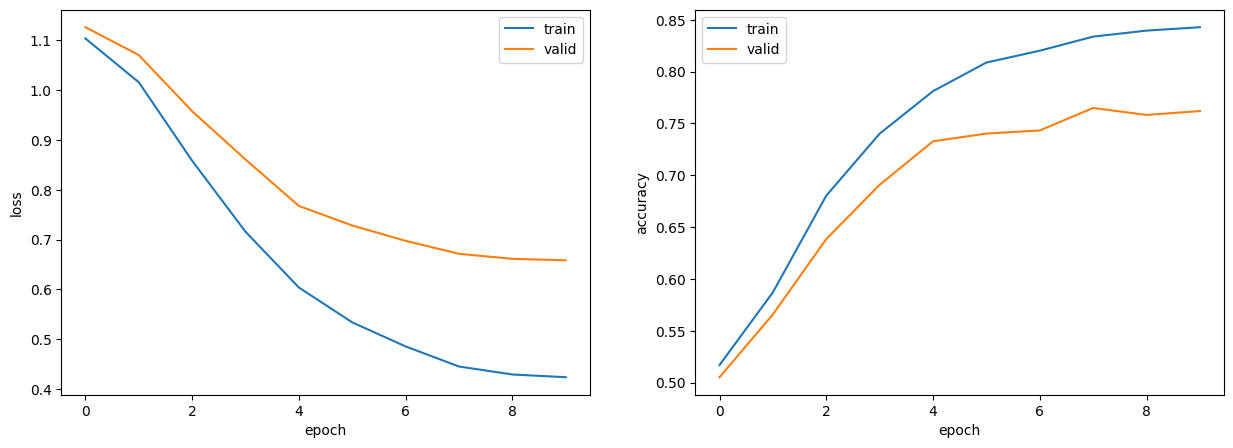

正解率（学習データ）：0.843
正解率（評価データ）：0.776


In [14]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 83

In [15]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [16]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2677, accuracy_train: 0.3901, loss_valid: 1.2599, accuracy_valid: 0.3990, 10.6376sec
epoch: 2, loss_train: 1.2724, accuracy_train: 0.4058, loss_valid: 1.2853, accuracy_valid: 0.4027, 9.9498sec
epoch: 3, loss_train: 1.2809, accuracy_train: 0.4212, loss_valid: 1.3011, accuracy_valid: 0.4109, 10.0106sec
epoch: 4, loss_train: 1.2025, accuracy_train: 0.4684, loss_valid: 1.2263, accuracy_valid: 0.4469, 9.9633sec
epoch: 5, loss_train: 1.0864, accuracy_train: 0.5743, loss_valid: 1.1444, accuracy_valid: 0.5262, 10.0047sec
epoch: 6, loss_train: 0.9458, accuracy_train: 0.6665, loss_valid: 0.9917, accuracy_valid: 0.6370, 9.6929sec
epoch: 7, loss_train: 0.8931, accuracy_train: 0.6921, loss_valid: 0.9573, accuracy_valid: 0.6602, 10.2505sec
epoch: 8, loss_train: 0.8546, accuracy_train: 0.7084, loss_valid: 0.9262, accuracy_valid: 0.6737, 9.9283sec
epoch: 9, loss_train: 0.8210, accuracy_train: 0.7204, loss_valid: 0.9028, accuracy_valid: 0.6841, 9.9610sec
epoch: 10, loss_train: 0

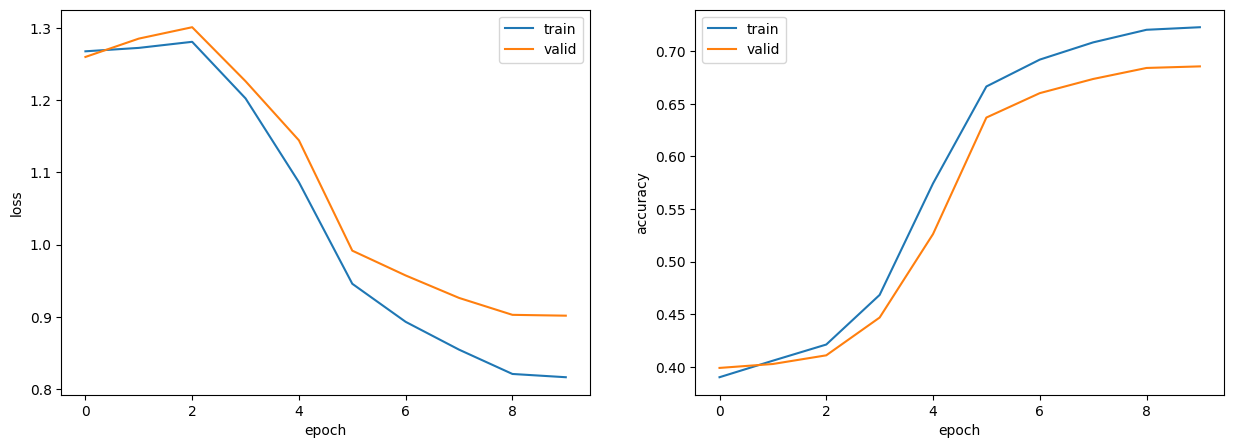

正解率（学習データ）：0.723
正解率（評価データ）：0.693


In [17]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 84

ここでは、idに対するgoogleがやってくれた学習済みの中間状態をweightsに入れていく

In [18]:
# 学習済み単語ベクトルのダウンロード
import gdown

url = 'https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:25<00:00, 64.6MB/s]


'GoogleNews-vectors-negative300.bin.gz'

In [19]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1#ここでもさっき81でpadding_idx=len(set(word2id.values())) とした理由分かった
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):#もちろんiは0から
  #if i==0:
    #print(i)
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9174 / 9406
torch.Size([9406, 300])


85からの部分。

In [20]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)# ここでパッディング指定
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)# ここでパッディング指定
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)#ここで双方向RNN使う
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

In [21]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)#パッディング処理のid指定

epoch: 1, loss_train: 1.1743, accuracy_train: 0.4116, loss_valid: 1.1806, accuracy_valid: 0.3997, 10.3416sec
epoch: 2, loss_train: 1.1828, accuracy_train: 0.4223, loss_valid: 1.2156, accuracy_valid: 0.4012, 10.0467sec
epoch: 3, loss_train: 1.0700, accuracy_train: 0.5795, loss_valid: 1.1018, accuracy_valid: 0.5576, 9.9456sec
epoch: 4, loss_train: 0.9953, accuracy_train: 0.6289, loss_valid: 1.0254, accuracy_valid: 0.6287, 9.4713sec
epoch: 5, loss_train: 1.0709, accuracy_train: 0.5999, loss_valid: 1.1474, accuracy_valid: 0.5531, 10.9393sec
epoch: 6, loss_train: 1.0187, accuracy_train: 0.6044, loss_valid: 1.0619, accuracy_valid: 0.5816, 10.0669sec
epoch: 7, loss_train: 0.9233, accuracy_train: 0.6546, loss_valid: 0.9645, accuracy_valid: 0.6422, 10.1317sec
epoch: 8, loss_train: 0.9878, accuracy_train: 0.6283, loss_valid: 1.0512, accuracy_valid: 0.6115, 11.0110sec
epoch: 9, loss_train: 0.9177, accuracy_train: 0.6521, loss_valid: 0.9796, accuracy_valid: 0.6265, 9.7444sec
epoch: 10, loss_train:

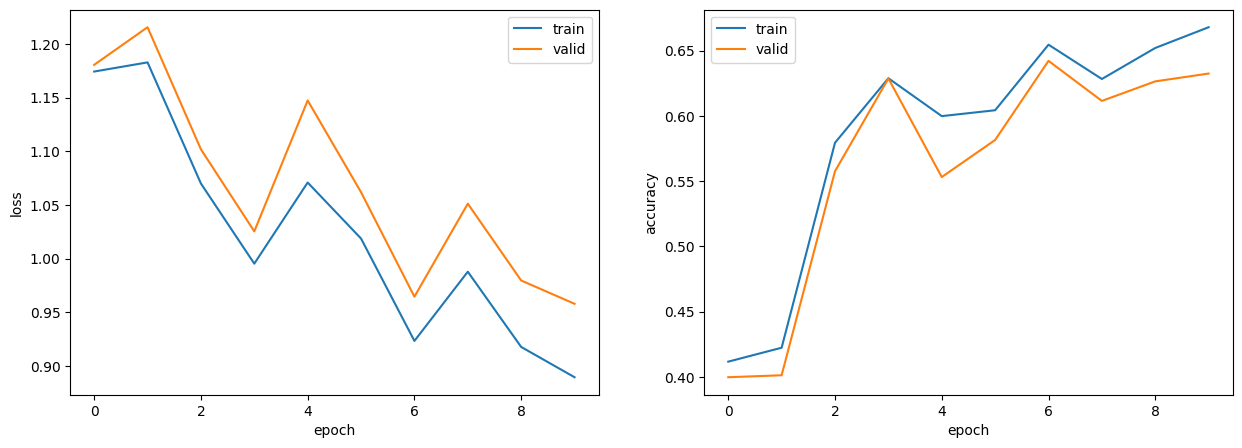

正解率（学習データ）：0.668
正解率（評価データ）：0.653


In [22]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 85

In [23]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1285, accuracy_train: 0.5039, loss_valid: 1.1523, accuracy_valid: 0.4993, 11.3467sec
epoch: 2, loss_train: 1.0834, accuracy_train: 0.5690, loss_valid: 1.1087, accuracy_valid: 0.5531, 11.6382sec
epoch: 3, loss_train: 1.0099, accuracy_train: 0.6244, loss_valid: 1.0318, accuracy_valid: 0.6063, 12.1763sec
epoch: 4, loss_train: 1.0370, accuracy_train: 0.6053, loss_valid: 1.0701, accuracy_valid: 0.5861, 11.1881sec
epoch: 5, loss_train: 1.1073, accuracy_train: 0.5718, loss_valid: 1.1568, accuracy_valid: 0.5464, 11.2047sec
epoch: 6, loss_train: 0.9818, accuracy_train: 0.6337, loss_valid: 1.0281, accuracy_valid: 0.6153, 11.1925sec
epoch: 7, loss_train: 0.9216, accuracy_train: 0.6675, loss_valid: 0.9614, accuracy_valid: 0.6564, 10.9409sec
epoch: 8, loss_train: 0.9377, accuracy_train: 0.6547, loss_valid: 0.9858, accuracy_valid: 0.6475, 10.9133sec
epoch: 9, loss_train: 0.9503, accuracy_train: 0.6484, loss_valid: 0.9981, accuracy_valid: 0.6385, 12.0101sec
epoch: 10, loss_tra

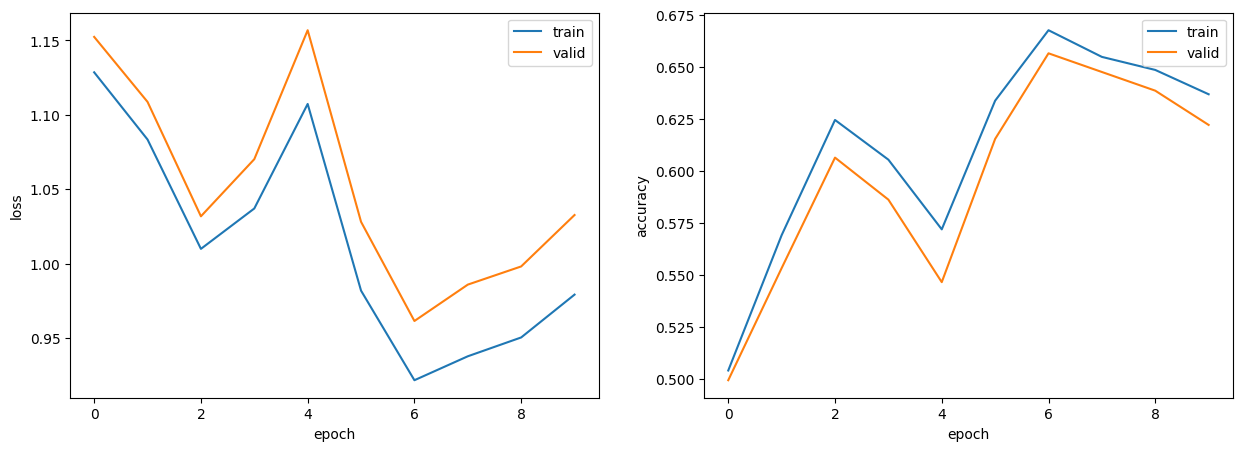

正解率（学習データ）：0.637
正解率（評価データ）：0.632


In [24]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 86

In [25]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out


In [26]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))#一番最後の単語はパッディング扱い。
OUTPUT_SIZE = 4#答えは４つのうちのどれか
OUT_CHANNELS = 100#cの次元数
KERNEL_HEIGHTS = 3#3つの並びに使っていくt-1,t,t+1
STRIDE = 1
PADDING = 1#STRIDEが1だからそれに対応してTと0の時に一番最後できないから、その時1で埋める。

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))#多分(batch_size, 4(4は4つの答えがあるから))だからだと思う。

tensor([[0.2438, 0.2621, 0.2904, 0.2036]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2571, 0.2640, 0.2538, 0.2251]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2203, 0.2944, 0.2546, 0.2307]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2604, 0.2484, 0.3032, 0.1880]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2417, 0.2651, 0.3003, 0.1929]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2786, 0.2239, 0.2782, 0.2192]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2650, 0.2504, 0.2691, 0.2155]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2167, 0.2750, 0.2903, 0.2181]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2518, 0.2543, 0.2834, 0.2105]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2549, 0.2487, 0.2965, 0.1999]], grad_fn=<SoftmaxBackward0>)


## 87

In [27]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2#ここ
BATCH_SIZE = 64#ここ
NUM_EPOCHS = 10#ここ

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義（ここ）
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義(ここ)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習（collate_fn=Padsequence(PADDING_IDX)でバッチサイズ処理のpadding埋め）
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0644, accuracy_train: 0.5546, loss_valid: 1.0735, accuracy_valid: 0.5659, 13.4719sec
epoch: 2, loss_train: 0.9862, accuracy_train: 0.6270, loss_valid: 1.0079, accuracy_valid: 0.6317, 8.9494sec
epoch: 3, loss_train: 0.9106, accuracy_train: 0.6875, loss_valid: 0.9457, accuracy_valid: 0.6677, 9.0141sec
epoch: 4, loss_train: 0.8532, accuracy_train: 0.7024, loss_valid: 0.9031, accuracy_valid: 0.6909, 8.5287sec
epoch: 5, loss_train: 0.8064, accuracy_train: 0.7248, loss_valid: 0.8677, accuracy_valid: 0.6976, 8.9786sec
epoch: 6, loss_train: 0.7756, accuracy_train: 0.7344, loss_valid: 0.8471, accuracy_valid: 0.7066, 8.9612sec
epoch: 7, loss_train: 0.7546, accuracy_train: 0.7424, loss_valid: 0.8333, accuracy_valid: 0.7096, 8.8579sec
epoch: 8, loss_train: 0.7419, accuracy_train: 0.7464, loss_valid: 0.8260, accuracy_valid: 0.7141, 8.7678sec
epoch: 9, loss_train: 0.7365, accuracy_train: 0.7475, loss_valid: 0.8217, accuracy_valid: 0.7163, 9.0071sec
epoch: 10, loss_train: 0.73

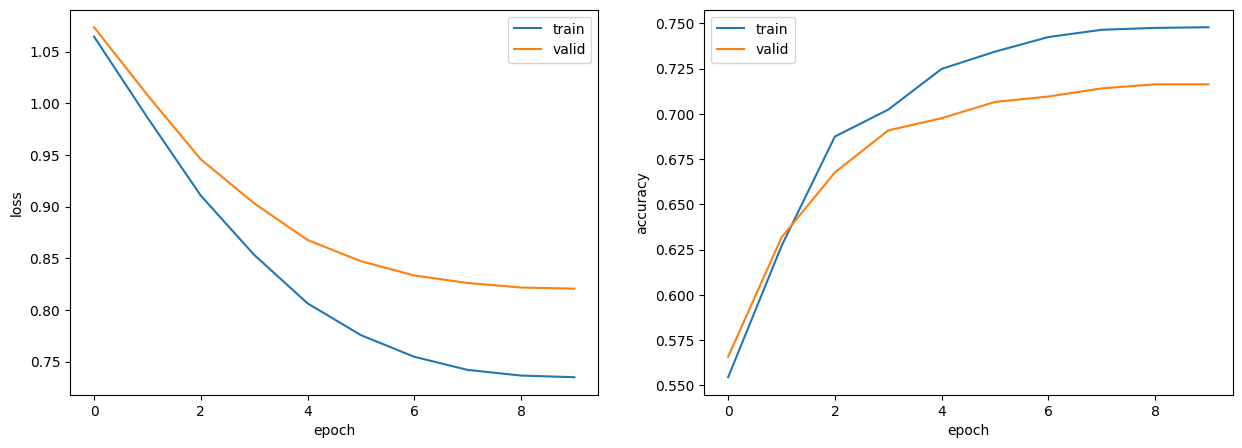

正解率（学習データ）：0.748
正解率（評価データ）：0.717


In [28]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 88

In [29]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [30]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [31]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.cuda.set_device(0)

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)

  return loss_valid

In [33]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=720)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2023-07-09 09:41:53,899] A new study created in memory with name: no-name-3fba91e2-9e34-4aeb-adca-f18798cbf7b7
<ipython-input-31-3ab730326b75>:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
<ipython-input-31-3ab730326b75>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-31-3ab730326b75>:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...)

epoch: 1, loss_train: 0.8264, accuracy_train: 0.7171, loss_valid: 0.8919, accuracy_valid: 0.6924, 36.4719sec
epoch: 2, loss_train: 0.6177, accuracy_train: 0.7823, loss_valid: 0.7512, accuracy_valid: 0.7298, 34.4519sec
epoch: 3, loss_train: 0.4463, accuracy_train: 0.8455, loss_valid: 0.6476, accuracy_valid: 0.7665, 33.4390sec
epoch: 4, loss_train: 0.3182, accuracy_train: 0.8906, loss_valid: 0.5760, accuracy_valid: 0.7927, 34.4623sec
epoch: 5, loss_train: 0.2225, accuracy_train: 0.9562, loss_valid: 0.5417, accuracy_valid: 0.7979, 34.3896sec
epoch: 6, loss_train: 0.1573, accuracy_train: 0.9710, loss_valid: 0.5191, accuracy_valid: 0.8129, 34.4144sec
epoch: 7, loss_train: 0.1132, accuracy_train: 0.9876, loss_valid: 0.4917, accuracy_valid: 0.8219, 34.2257sec
epoch: 8, loss_train: 0.0818, accuracy_train: 0.9942, loss_valid: 0.4767, accuracy_valid: 0.8331, 33.7108sec
epoch: 9, loss_train: 0.0655, accuracy_train: 0.9963, loss_valid: 0.4869, accuracy_valid: 0.8271, 34.4448sec
epoch: 10, loss_tra

[I 2023-07-09 09:56:46,547] Trial 0 finished with value: 0.47972847107100075 and parameters: {'emb_size': 300.0, 'out_channels': 150.0, 'drop_rate': 0.2, 'learning_rate': 0.04770580431792914, 'momentum': 0.5, 'batch_size': 32.0}. Best is trial 0 with value: 0.47972847107100075.


Best trial:
  Value: 0.480
  Params: 
    emb_size: 300.0
    out_channels: 150.0
    drop_rate: 0.2
    learning_rate: 0.04770580431792914
    momentum: 0.5
    batch_size: 32.0


In [34]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.cuda.set_device(0)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

textCNN(
  (emb): Embedding(9406, 300, padding_idx=9405)
  (convs): ModuleList(
    (0): Conv2d(1, 150, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 150, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 150, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=450, out_features=4, bias=True)
)
epoch: 1, loss_train: 0.4915, accuracy_train: 0.8217, loss_valid: 0.6642, accuracy_valid: 0.7552, 34.6501sec
epoch: 2, loss_train: 0.2184, accuracy_train: 0.9349, loss_valid: 0.5473, accuracy_valid: 0.8129, 34.1511sec
epoch: 3, loss_train: 0.1261, accuracy_train: 0.9642, loss_valid: 0.6216, accuracy_valid: 0.7987, 33.2765sec
epoch: 4, loss_train: 0.0554, accuracy_train: 0.9890, loss_valid: 0.5628, accuracy_valid: 0.8256, 34.8898sec
epoch: 5, loss_train: 0.0432, accuracy_train: 0.9912, loss_valid: 0.6476, accuracy_valid: 0.8151, 32.6964sec
epoch: 6, loss_train: 0.0264, accuracy_train: 0.9965, l

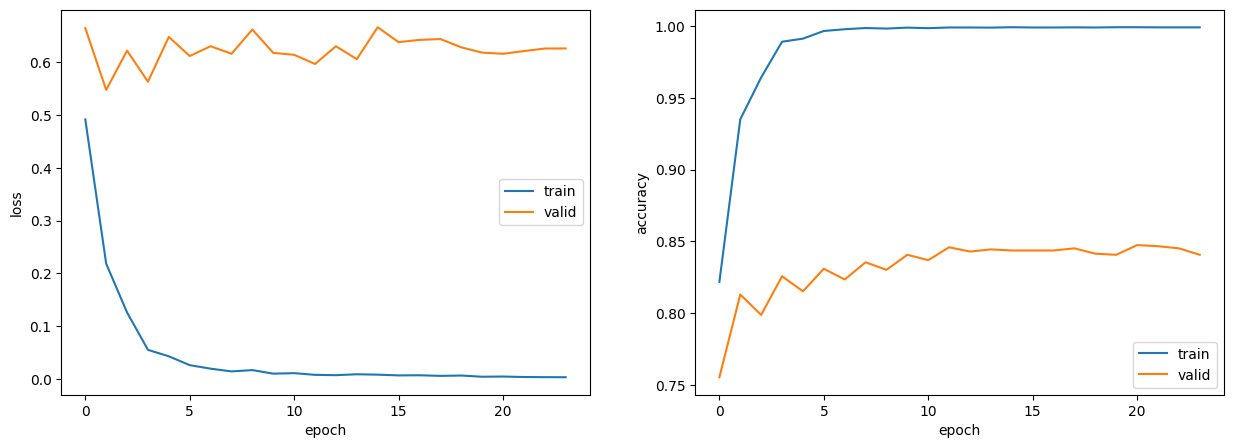

正解率（学習データ）：0.999
正解率（評価データ）：0.850


In [35]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 89

In [36]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00


In [37]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [38]:
# Datasetの定義
class NewsDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [39]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
         2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

In [41]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [42]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.0899, accuracy_train: 0.9494, loss_valid: 0.1183, accuracy_valid: 0.9199, 72.9899sec
epoch: 2, loss_train: 0.0475, accuracy_train: 0.9760, loss_valid: 0.1007, accuracy_valid: 0.9311, 76.0454sec
epoch: 3, loss_train: 0.0294, accuracy_train: 0.9864, loss_valid: 0.1050, accuracy_valid: 0.9259, 75.4489sec
epoch: 4, loss_train: 0.0201, accuracy_train: 0.9919, loss_valid: 0.1074, accuracy_valid: 0.9349, 71.0914sec


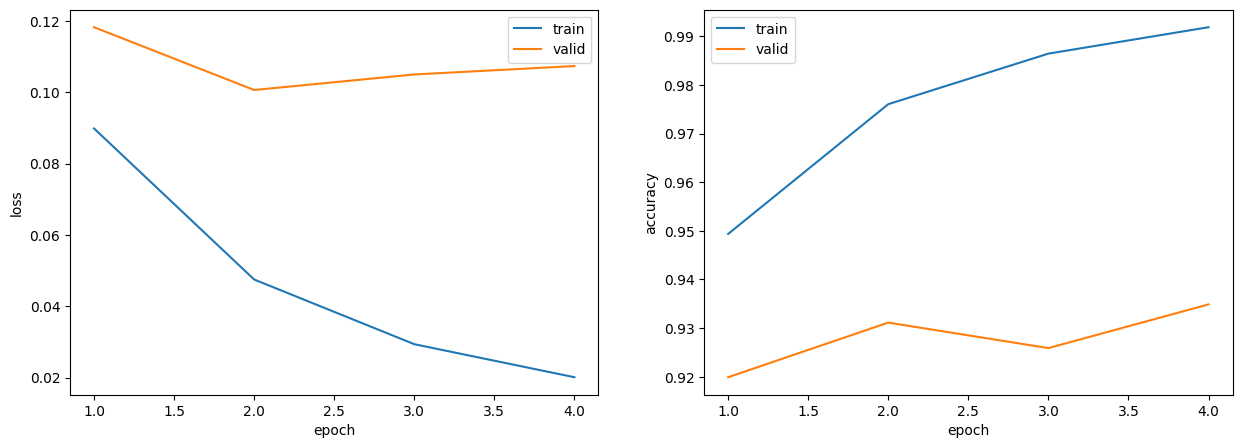

In [43]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [44]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

正解率（学習データ）：0.992
正解率（検証データ）：0.935
正解率（評価データ）：0.945
